

## Prevendo o Nível de Satisfação dos Clientes do Santander

### Objetivos do projeto:
##### Esse projeto busca prever a probabilidade de que cada cliente no conjunto de testes seja um cliente insatisfeito.

Link do desafio no site do Kaggle: https://www.kaggle.com/c/santander-customer-satisfaction

Private score na competição: 0.82284

____________

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.feature_selection import VarianceThreshold

from xgboost import XGBClassifier
from sklearn import metrics
import pickle


import warnings
warnings.filterwarnings("ignore")

Print do shape dos dados e da distribuição da variável Target:

https://www.kaggle.com/prashant111/comprehensive-guide-on-feature-selection

In [2]:
df = pd.read_csv('train.csv')
print(df.shape)
print("")
print(df.TARGET.value_counts())

(76020, 371)

0    73012
1     3008
Name: TARGET, dtype: int64


Verifica se há valores NaN:

In [3]:
if df.columns.isnull().any():
    for column in df.columns:
       print('{0} existem {1} valores NaN'.format(column, df[column].isnull().sum()))
else:
    print('Não há valores NaN')

Não há valores NaN


### Seleção de variáveis:

Remoção de variáveis constantes

Variance threshold remove todas as variáveis cuja variância não atinge um limite 'X'. 

Por padrão, ele remove todas  as colunas em que a variância das observações é igual a zero, ou seja, os recursos que têm o mesmo valor em todas as observações.

Link extra:  https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html

In [4]:
var_zero = VarianceThreshold(threshold=0)
var_zero.fit(df)
col_var_zero = [x for x in df.columns if x not in df.columns[var_zero.get_support()]]
print('Quantidade de variáveis com variância igual a zero:','\n', len(col_var_zero))
print("")
print("Variáveis com variância igual a zero e removidas:","\n", col_var_zero)

# get.support() retorna todas as colunas com variância diferente de zero:

df = df[df.columns[var_zero.get_support()]]
print("")
print('Shape dos dados:', df.shape)

Quantidade de variáveis com variância igual a zero: 
 34

Variáveis com variância igual a zero e removidas: 
 ['ind_var2_0', 'ind_var2', 'ind_var27_0', 'ind_var28_0', 'ind_var28', 'ind_var27', 'ind_var41', 'ind_var46_0', 'ind_var46', 'num_var27_0', 'num_var28_0', 'num_var28', 'num_var27', 'num_var41', 'num_var46_0', 'num_var46', 'saldo_var28', 'saldo_var27', 'saldo_var41', 'saldo_var46', 'imp_amort_var18_hace3', 'imp_amort_var34_hace3', 'imp_reemb_var13_hace3', 'imp_reemb_var33_hace3', 'imp_trasp_var17_out_hace3', 'imp_trasp_var33_out_hace3', 'num_var2_0_ult1', 'num_var2_ult1', 'num_reemb_var13_hace3', 'num_reemb_var33_hace3', 'num_trasp_var17_out_hace3', 'num_trasp_var33_out_hace3', 'saldo_var2_ult1', 'saldo_medio_var13_medio_hace3']

Shape dos dados: (76020, 337)


Em alguns casos, e isso depende do tipo de problema, alguns recursos podem apresentar variaância muito próximas a zero e consequentemente apresentar pouco ou nenhum valor preditivo, e podem ser removidas.

Como por exemplo a variável 'ind_var1_0'. A variável apresenta desvio padrão próximo a zero, com as observações booleanas (0 ou 1) onde a variável 0 aparece em mais de 98% dos casos. 

In [5]:
print("Desvio padrão:", df.ind_var1_0.std())
print("")
print("Distribuição das observações:")
df.ind_var1_0.value_counts(normalize=True)

Desvio padrão: 0.10642549323816614

Distribuição das observações:


0    0.988542
1    0.011458
Name: ind_var1_0, dtype: float64

Nesse caso, removerei recursos em que uma mesma observação aparece em mais de 95% dos casos. Pois provavelmente apresentem pouco valor preditivo.

In [6]:
var_zero_ = VarianceThreshold(threshold=0.03)
var_zero_.fit(df)
col_var_zero_ = [x for x in df.columns if x not in df.columns[var_zero_.get_support()]]
print('Quantidade de variáveis com variância perto de zero:','\n', len(col_var_zero_))
print("")
print("Variáveis com variância perto de zero e removidas:","\n", col_var_zero_)

df = df[df.columns[var_zero_.get_support()]]
print('Shape dos dados:', df.shape)

Quantidade de variáveis com variância perto de zero: 
 83

Variáveis com variância perto de zero e removidas: 
 ['ind_var1_0', 'ind_var1', 'ind_var6_0', 'ind_var6', 'ind_var8', 'ind_var13_largo_0', 'ind_var13_largo', 'ind_var13_medio_0', 'ind_var13_medio', 'ind_var14_0', 'ind_var14', 'ind_var17_0', 'ind_var17', 'ind_var18_0', 'ind_var18', 'ind_var19', 'ind_var20_0', 'ind_var20', 'ind_var25_cte', 'ind_var26_0', 'ind_var26_cte', 'ind_var26', 'ind_var25_0', 'ind_var25', 'ind_var29_0', 'ind_var29', 'ind_var30_0', 'ind_var31_0', 'ind_var31', 'ind_var32_cte', 'ind_var32_0', 'ind_var32', 'ind_var33_0', 'ind_var33', 'ind_var34_0', 'ind_var34', 'ind_var40_0', 'ind_var40', 'ind_var39', 'ind_var44_0', 'ind_var44', 'num_var6_0', 'num_var6', 'num_var13_medio_0', 'num_var13_medio', 'num_var18_0', 'num_var18', 'num_var20', 'num_var29_0', 'num_var29', 'num_var32_0', 'num_var32', 'num_var33_0', 'num_var33', 'num_var34_0', 'num_var34', 'num_var44_0', 'num_var44', 'ind_var7_emit_ult1', 'ind_var7_recib_ul

Variáveis idênticas:

Em um conjunto de dados desse tipo, alguma variáveis podem conter as mesmas observações e consequentemente contendo o mesmo valor preditivo, o código abaixo identifica essas variáveis e remove uma delas. 

In [7]:
var_iguais = []

for i in range(len(df.columns)-1):
    v = df[df.columns[i]].values
    for j in range(i+1,len(df.columns)):
        if np.array_equal(v,df[df.columns[j]].values):
            print(df.columns[i],'=' ,df.columns[j])
            var_iguais.append(df.columns[j])
print("")
print('Colunas removidas:', var_iguais)  
df.drop(var_iguais, axis=1, inplace=True)
print("")
print('Shape dos dados:', df.shape)

ind_var37_0 = ind_var37
num_var26_0 = num_var26
num_var25_0 = num_var25
num_var37_0 = num_var37
num_var40 = num_var39
saldo_var6 = saldo_var29
saldo_var13_medio = saldo_medio_var13_medio_ult1
delta_imp_reemb_var13_1y3 = delta_num_reemb_var13_1y3
delta_imp_reemb_var17_1y3 = delta_num_reemb_var17_1y3
delta_imp_reemb_var33_1y3 = delta_num_reemb_var33_1y3
delta_imp_trasp_var17_in_1y3 = delta_num_trasp_var17_in_1y3
delta_imp_trasp_var17_out_1y3 = delta_num_trasp_var17_out_1y3
delta_imp_trasp_var33_in_1y3 = delta_num_trasp_var33_in_1y3
delta_imp_trasp_var33_out_1y3 = delta_num_trasp_var33_out_1y3

Colunas removidas: ['ind_var37', 'num_var26', 'num_var25', 'num_var37', 'num_var39', 'saldo_var29', 'saldo_medio_var13_medio_ult1', 'delta_num_reemb_var13_1y3', 'delta_num_reemb_var17_1y3', 'delta_num_reemb_var33_1y3', 'delta_num_trasp_var17_in_1y3', 'delta_num_trasp_var17_out_1y3', 'delta_num_trasp_var33_in_1y3', 'delta_num_trasp_var33_out_1y3']

Shape dos dados: (76020, 240)


Multicolinearidade:

Trata-se de avaliar se uma variável preditora está correlacionada com outra variável preditora. Na prática variáveis correlacionadas podem apresentar o mesmo valor preditivo ao modelo ou, em alguns casos, até mesmo diminuir a performance do resultado final.

O código abaixo encontra variáveis em que o coeficiente de correlação de Pearson é igual ou maior que 0.9, e então, remove uma delas.

Link extra: https://blog.minitab.com/pt/basta-lidando-com-a-multicolinearidade-na-analise-de-regressao

In [8]:
def correlation(dataset, threshold):
    col_corr = set()  
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: 
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

corr_features = correlation(df.drop(['ID','TARGET'], axis=1), 0.9)
print('Variáveis correlacionadas e removidas: ', len(set(corr_features)))
print(corr_features)
df.drop(corr_features, axis=1, inplace=True)
print("")
print('Shape dos dados:', df.shape)

Variáveis correlacionadas e removidas:  92
{'saldo_medio_var29_ult1', 'num_var41_0', 'saldo_medio_var33_ult1', 'num_op_var40_ult3', 'saldo_medio_var13_medio_ult3', 'saldo_medio_var13_largo_ult1', 'num_meses_var8_ult3', 'num_var40', 'ind_var41_0', 'saldo_medio_var12_ult3', 'saldo_var25', 'num_meses_var13_corto_ult3', 'saldo_medio_var13_corto_ult3', 'num_var13', 'num_var25_0', 'num_op_var39_efect_ult1', 'saldo_medio_var13_corto_ult1', 'num_var5_0', 'num_var13_largo', 'num_var42_0', 'num_op_var41_comer_ult3', 'num_var40_0', 'saldo_medio_var17_ult1', 'saldo_medio_var8_ult1', 'saldo_medio_var17_hace3', 'num_op_var39_comer_ult3', 'num_meses_var5_ult3', 'delta_num_aport_var17_1y3', 'imp_aport_var17_hace3', 'imp_venta_var44_ult1', 'num_var31_0', 'num_var35', 'ind_var10cte_ult1', 'delta_num_venta_var44_1y3', 'num_var45_hace2', 'delta_num_compra_var44_1y3', 'saldo_medio_var12_ult1', 'saldo_medio_var17_ult3', 'num_meses_var12_ult3', 'num_op_var39_hace2', 'saldo_var18', 'imp_op_var41_comer_ult3', 

## Outliers:

São valores discrepantes nas observações e que geralmente trazem viés negativo ao resultado. A identificação e tratamento de valores outliers variam muito de problema pra problema e essa etapa requer muito cuidado e em alguns casos alto conhecimento prévio sobre os dados coletados.

Nesse projeto não sabemos a descrição das variáveis, o que dificulta essa etapa. Minha estratégia foi tentar encontrar variáveis em que valores outliers aparecessem poucas vezes pra facilitar a intepretação e evitar decisões erradas, já que não sei exatamente o que cada variável significa.

O código abaixo retorna um dataframe com as variáveis que contém algum outlier, bem como a quantidade de valores discrepantes em cada uma dessas variáveis.

In [9]:
%%time

def detect_outlier(data, threshold=3):
    df_outlier = pd.DataFrame()
    
    for col in data.columns:
        mean, std = np.mean(data[col]), np.std(data[col])
        outliers=[]
        
        for y in data[col]:
            z_score = (y - mean)/std
            
            if np.abs(z_score) > threshold or np.abs(z_score) < -threshold:  
                outliers.append(y)
        df2 = pd.DataFrame({'variável': [col], 'quantidade': [len(set(outliers))]})
        df_outlier = df_outlier.append(df2)
        df_outlier = df_outlier.loc[df_outlier.quantidade > 0]  
          
    return df_outlier

outliers = detect_outlier(df)

Wall time: 30.1 s


In [10]:
# variáveis que contém apenas um valor outlier
list(outliers.loc[outliers.quantidade == 1]['variável'])

['var3',
 'ind_var5_0',
 'ind_var8_0',
 'ind_var12_0',
 'ind_var12',
 'ind_var13_0',
 'ind_var24_0',
 'ind_var37_cte',
 'num_var20_0',
 'delta_imp_amort_var18_1y3',
 'delta_imp_aport_var13_1y3',
 'delta_imp_aport_var17_1y3',
 'delta_imp_aport_var33_1y3',
 'delta_imp_compra_var44_1y3',
 'delta_imp_reemb_var13_1y3',
 'delta_imp_reemb_var17_1y3',
 'delta_imp_reemb_var33_1y3',
 'delta_imp_trasp_var17_in_1y3',
 'delta_imp_trasp_var17_out_1y3',
 'delta_imp_trasp_var33_in_1y3',
 'delta_imp_trasp_var33_out_1y3',
 'delta_imp_venta_var44_1y3',
 'imp_reemb_var17_hace3',
 'ind_var10_ult1',
 'ind_var43_emit_ult1',
 'saldo_medio_var29_hace3',
 'TARGET']

In [11]:
# observações mínimas em cada uma dessas variáveis
df[outliers.loc[outliers.quantidade == 1]['variável']].min()

var3                            -999999.0
ind_var5_0                            0.0
ind_var8_0                            0.0
ind_var12_0                           0.0
ind_var12                             0.0
ind_var13_0                           0.0
ind_var24_0                           0.0
ind_var37_cte                         0.0
num_var20_0                           0.0
delta_imp_amort_var18_1y3             0.0
delta_imp_aport_var13_1y3            -1.0
delta_imp_aport_var17_1y3            -1.0
delta_imp_aport_var33_1y3            -1.0
delta_imp_compra_var44_1y3           -1.0
delta_imp_reemb_var13_1y3             0.0
delta_imp_reemb_var17_1y3            -1.0
delta_imp_reemb_var33_1y3             0.0
delta_imp_trasp_var17_in_1y3         -1.0
delta_imp_trasp_var17_out_1y3         0.0
delta_imp_trasp_var33_in_1y3         -1.0
delta_imp_trasp_var33_out_1y3         0.0
delta_imp_venta_var44_1y3            -1.0
imp_reemb_var17_hace3                 0.0
ind_var10_ult1                    

Algunas descriçoes sobre a variável 'var3' me permitiram a sugestão de substituir o valor '-999999' pelo valor '2', que é o mais frequente entre as observações

In [12]:
df.var3.describe()

count     76020.000000
mean      -1523.199277
std       39033.462364
min     -999999.000000
25%           2.000000
50%           2.000000
75%           2.000000
max         238.000000
Name: var3, dtype: float64

In [13]:
df.var3.value_counts()

 2         74165
 8           138
-999999      116
 9           110
 3           108
           ...  
 177           1
 87            1
 151           1
 215           1
 191           1
Name: var3, Length: 208, dtype: int64

In [14]:
df.var3.replace(-999999, 2, inplace=True)

No mesmo sentido, identifiquei os valores outliers máximos, e depois de uma análise descritiva, optei por substituir os '9999999999' por zero, que é o valor mais frequente em cada uma dessas variáveis, conforme as descrições:

In [15]:
outilier_max = pd.DataFrame(df[outliers.loc[outliers.quantidade == 1]['variável']].max().astype('int64')).reset_index()
outilier_max.columns = ['Variável', 'Valor']
outilier_max.sort_values('Valor', ascending=False)

,Variável,Valor
13,delta_imp_compra_var44_1y3,9999999999
14,delta_imp_reemb_var13_1y3,9999999999
21,delta_imp_venta_var44_1y3,9999999999
20,delta_imp_trasp_var33_out_1y3,9999999999
19,delta_imp_trasp_var33_in_1y3,9999999999
18,delta_imp_trasp_var17_out_1y3,9999999999
17,delta_imp_trasp_var17_in_1y3,9999999999
16,delta_imp_reemb_var33_1y3,9999999999
9,delta_imp_amort_var18_1y3,9999999999
10,delta_imp_aport_var13_1y3,9999999999


In [16]:
for i in outilier_max[outilier_max.Valor == 9999999999]['Variável']:
    print(i,'\n', df[i].astype('int64').value_counts(), '\n')

delta_imp_amort_var18_1y3 
 0             76018
9999999999        2
Name: delta_imp_amort_var18_1y3, dtype: int64 

delta_imp_aport_var13_1y3 
  0             73966
-1              1675
 9999999999      370
 1                 5
 4                 2
 5                 1
 2                 1
Name: delta_imp_aport_var13_1y3, dtype: int64 

delta_imp_aport_var17_1y3 
  0             75962
 9999999999       39
-1                17
 1                 2
Name: delta_imp_aport_var17_1y3, dtype: int64 

delta_imp_aport_var33_1y3 
  0             76002
-1                17
 9999999999        1
Name: delta_imp_aport_var33_1y3, dtype: int64 

delta_imp_compra_var44_1y3 
  0             75928
 9999999999       70
-1                18
 6                 1
 3                 1
 2                 1
 1                 1
Name: delta_imp_compra_var44_1y3, dtype: int64 

delta_imp_reemb_var13_1y3 
 0             75982
9999999999       38
Name: delta_imp_reemb_var13_1y3, dtype: int64 

delta_imp_reemb_var17

In [17]:
df.replace(9999999999, 0, inplace=True)

In [18]:
# Analisando o restante das variáveis que possuem uma observação outlier
df[outliers[outliers.quantidade==1]['variável']].astype('int64').describe().T

,count,mean,std,min,25%,50%,75%,max
var3,76020.0,2.716483,9.447971,0.0,2.0,2.0,2.0,238.0
ind_var5_0,76020.0,0.958024,0.200535,0.0,1.0,1.0,1.0,1.0
ind_var8_0,76020.0,0.032833,0.178202,0.0,0.0,0.0,0.0,1.0
ind_var12_0,76020.0,0.067522,0.250925,0.0,0.0,0.0,0.0,1.0
ind_var12,76020.0,0.045462,0.208316,0.0,0.0,0.0,0.0,1.0
ind_var13_0,76020.0,0.052249,0.222531,0.0,0.0,0.0,0.0,1.0
ind_var24_0,76020.0,0.042370,0.201434,0.0,0.0,0.0,0.0,1.0
ind_var37_cte,76020.0,0.072297,0.258980,0.0,0.0,0.0,0.0,1.0
num_var20_0,76020.0,0.010892,0.180437,0.0,0.0,0.0,0.0,3.0
delta_imp_amort_var18_1y3,76020.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [19]:
df.imp_reemb_var17_hace3.value_counts()

0.00        76019
12027.15        1
Name: imp_reemb_var17_hace3, dtype: int64

In [20]:
df.drop('imp_reemb_var17_hace3', axis=1, inplace=True)

In [21]:
df.saldo_medio_var29_hace3.value_counts()

0.0      76019
145.2        1
Name: saldo_medio_var29_hace3, dtype: int64

In [22]:
df.drop('saldo_medio_var29_hace3', axis=1, inplace=True)

Como visto acima, as variáveis 'imp_reemb_var17_hace3' e 'saldo_medio_var29_hace3' possuem apenas observações iguais a zero e o valor outlier, removendo o outlier essa variável se torna constante e portanto sem valor preditivo, por isso foram removidas.

Ao tratar outliers, fiz transformações nos dados que podem ter gerado mais algumas variáveis constantes e que a exemplo do realizado anteriormente, serão removidas.


In [23]:
var_zero = VarianceThreshold(threshold=0)
var_zero.fit(df)
col_var_zero = [x for x in df.columns if x not in df.columns[var_zero.get_support()]]
print('Quantidade de variáveis com variância igual a zero:','\n', len(col_var_zero))
print("")
print("Variáveis com variância igual a zero e removidas:","\n", col_var_zero)

# get.support() retorna todas as colunas com variância diferente de zero:
df = df[df.columns[var_zero.get_support()]]
print("")
print('Shape dos dados:', df.shape)

Quantidade de variáveis com variância igual a zero: 
 5

Variáveis com variância igual a zero e removidas: 
 ['delta_imp_amort_var18_1y3', 'delta_imp_reemb_var13_1y3', 'delta_imp_reemb_var33_1y3', 'delta_imp_trasp_var17_out_1y3', 'delta_imp_trasp_var33_out_1y3']

Shape dos dados: (76020, 141)


## Escolha do algortimo:

Com o código abaixo aplico cross validation utilizando 5 modelos de classificação distintos que me ajudam a escolher o melhor algoritmo para esse problema, a métrica utilizada é a curva roc e ao final vemos a média, valor máximo e desvio padrão dos resultados de cada das 5 iterações realizadas em cada algoritmo, além de boxplots com os resultados:

KNN: 0.588074 0.598203 (0.008990)
LR: 0.608139 0.615254 (0.007114)
LDA: 0.790330 0.798858 (0.007936)
CART: 0.575118 0.582192 (0.008143)
XGB : 0.825524 0.831218 (0.004073)


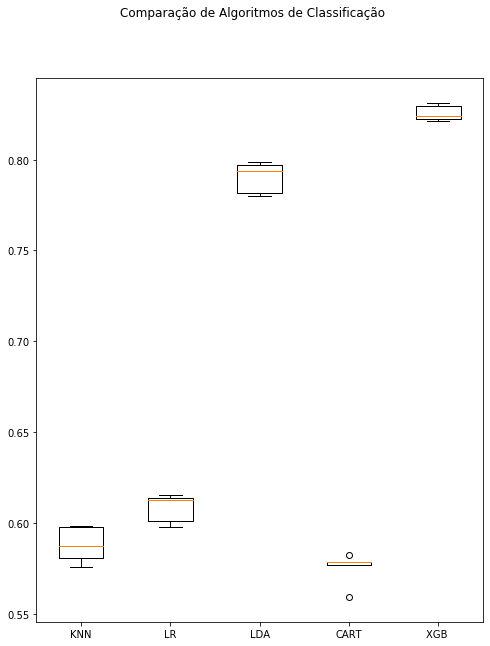

Wall time: 5min 26s


In [24]:
%%time

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


X = df.drop(['ID', 'TARGET'], axis=1).values
Y = df.TARGET.values

num_folds = 5

modelos = []
resultados = []
nomes = []

modelos.append(('KNN', KNeighborsClassifier()))
modelos.append(('LR', LogisticRegression()))
modelos.append(('LDA', LinearDiscriminantAnalysis()))
modelos.append(('CART', DecisionTreeClassifier()))
modelos.append(('XGB ', XGBClassifier()))


for nome, modelo in modelos:
    kfold = KFold(num_folds, True)
    cv_results = cross_val_score(modelo, X, Y, cv = kfold, scoring = 'roc_auc')
    resultados.append(cv_results)
    nomes.append(nome)
    msg = "%s: %f %f (%f)" % (nome, cv_results.mean(), cv_results.max(), cv_results.std())
    print(msg)


fig = plt.figure(figsize= (8,10))
fig.suptitle('Comparação de Algoritmos de Classificação')
ax = fig.add_subplot(111)
plt.boxplot(resultados)
ax.set_xticklabels(nomes)
plt.show()

Aqui aplico um método de otimização de hiperparâmetros do algortimo que obteve o melhor resultado, o XGBOOST:

Utlizando o grid search, https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [25]:
%%time

from sklearn.model_selection import GridSearchCV

estimator = XGBClassifier(objective= 'binary:logistic')
parameters = {'max_depth': range (3, 7, 1), 'n_estimators': range(100, 160, 10), 'learning_rate': [0.01, 0.05]}

grid_search = GridSearchCV(estimator=estimator, param_grid=parameters, 
                           scoring = 'roc_auc', n_jobs = -1, cv = 3,
                           verbose=True)

grid_search.fit(X, Y)
print("Auc: %.3f" % (grid_search.best_score_ * 100), '\n', grid_search.best_estimator_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 17.2min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 61.5min finished


Auc: 83.890 
 XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=140, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)
Wall time: 1h 2min 16s


Aqui aplico novamente cross validation, mas agora com o modelo escolhido e otimizado:

In [26]:
%%time

num_folds = 5
kfold = KFold(num_folds, True)

modelo = XGBClassifier(nthread=-1, max_depth=5, n_estimators=140, learning_rate=0.05)

resultado = cross_val_score(modelo, X, Y, cv = kfold, scoring = 'roc_auc')

print('\n', "Auc médio: %.3f%%" % (resultado.mean() * 100.0), '\n',
      'Auc max:', (resultado.max() * 100.0), '\n',                          
      'STD:',resultado.std(), '\n')


 Auc médio: 83.923% 
 Auc max: 84.80570287008891 
 STD: 0.005700238634261763 

Wall time: 3min 5s


Faço fit com o modelo já otimizado e salvo pra aplicar posteriormente:

In [27]:
modelo.fit(X,Y)
pickle.dump(modelo, open('model_xgb_Projeto_03_DSA.sav','wb'))

Carregando os dados de teste, verificando a existência de valores NaN e coletando as colunas utilizadas nos dados de treinamento para utilizar nos dados de teste.

In [32]:
colunas_treino = list(df.columns)
df_teste = pd.read_csv('test.csv')
df_teste = df_teste[colunas_treino[:-1]]

if df_teste.columns.isnull().any():
    for column in df_teste.columns:
       print('{0} existem {1} colunas com valores NaN'.format(column, df_teste[column].isnull().sum()))
else:
    print('Não há valores NaN')

Não há valores NaN


In [33]:
if len(colunas_treino) > len(list(df_teste.columns)):
    print( 'As variáveis', list(set(colunas_treino) - set(list(df_teste.columns))), 'não existem nos dados de teste')
    
else:
    print('Todas as variáveis existem no dados de teste')
    
if len(list(df_teste.columns)) > len(colunas_treino):
    print( 'As variáveis', list( set(list(df_teste.columns)) - set(colunas_treino)), 'não existem nos dados de treino')
    
else:
    print('Todas as variáveis existem no dados de treino')

As variáveis ['TARGET'] não existem nos dados de teste
Todas as variáveis existem no dados de treino


In [34]:
modelo = pickle.load(open('model_xgb_Projeto_03_DSA.sav', 'rb'))
X = df_teste.drop(['ID'], axis=1).values
previsoes = modelo.predict_proba(X)
df_teste['TARGET'] = previsoes[:,1]

submission = df_teste[['ID', 'TARGET']]
submission.to_csv('submission_DSA.csv', index=False, encoding="utf-8", header=True)